In [1]:
from keras.models import load_model

lc_model = load_model('./out/CharNet_LCv1.keras')
uc_model = load_model('./out/CharNet_UCv1.keras')

In [17]:
import numpy as np

class Model:
    def __init__(self, lc_model, uc_model):
        self.lc_model = lc_model
        self.uc_model = uc_model

        self.lc_indices = 'abcdefghijklmnopqrstuvwxyz'
        self.uc_indices = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

    def predict(self, x):
        lc_pred_proba = self.lc_model.predict(x)
        uc_pred_proba = self.uc_model.predict(x)

        # Get max confidence scores for both models
        lc_confidence = np.max(lc_pred_proba, axis=1)
        uc_confidence = np.max(uc_pred_proba, axis=1)

        # Get predictions for each model
        lc_pred = np.argmax(lc_pred_proba, axis=1)
        uc_pred = np.argmax(uc_pred_proba, axis=1)

        # Choose model based on confidence
        final_pred = np.where(lc_confidence > uc_confidence, lc_pred, uc_pred)
        final_chars = [self.lc_indices[i] if lc_confidence[j] > uc_confidence[j] else self.uc_indices[i] 
                       for j, i in enumerate(final_pred)]
        
        # add verbosity 
        print(f'Lowercase Prediction: {self.lc_indices[lc_pred[0]]} (Confidence: {lc_confidence})')
        print(f'Uppercase Prediction: {self.uc_indices[uc_pred[0]]} (Confidence: {uc_confidence})')

        return ''.join(final_chars)
    

model = Model(lc_model, uc_model)

In [4]:
import cv2, os
import numpy as np

import matplotlib.pyplot as plt


def crop_and_resize(img, final_size=(128, 128)):
    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    non_zero = cv2.findNonZero(img)

    x, y, w, h = cv2.boundingRect(non_zero)
    cropped = img[y:y+h, x:x+w]

    max_side = max(w, h)
    square_canvas = np.zeros((max_side, max_side), dtype=np.uint8)

    x_offset = (max_side - w) // 2
    y_offset = (max_side - h) // 2

    square_canvas[y_offset:y_offset+h, x_offset:x_offset+w] = cropped
    resized = cv2.resize(square_canvas, final_size, interpolation=cv2.INTER_AREA)

    return resized


def get_char_contours(img_path):
    """Extracts character contours from an image."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, img_bin = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)
    
    kernel = np.ones((3, 3), np.uint8)
    img_bin = cv2.erode(img_bin, kernel, iterations=1)
    
    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    
    return [c for c in contours if cv2.contourArea(c) > 25]


def get_char_imgs(img_path, contours):
    """Extracts character images using bounding boxes."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    char_imgs = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        char_img = img[y:y+h, x:x+w]
        char_img = crop_and_resize(char_img)

        # char_img = load_and_skeletonize(char_img)
        char_img = char_img.reshape(1, 128, 128, 1)
        
        char_imgs.append(char_img)

        plt.imshow(char_img[0, :, :, 0], cmap='gray')
        plt.show()
        
    return char_imgs

def predict_word(img_path, model):
    """Predicts the word from an image of handwritten text."""
    contours = get_char_contours(img_path)
    char_imgs = get_char_imgs(img_path, contours)
    word = ''
    
    for img in char_imgs:
        img = np.array(img, dtype=np.float32) / 255.0
        pred = model.predict(img)
        word += pred
    
    return word


def mark_words(img_path, model):
    """Marks words with bounding boxes and predicted text."""

    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, img_bin = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY_INV)
    
    kernel = np.ones((4, 4), np.uint8)
    img_dilated = cv2.dilate(img_bin, kernel, iterations=8)

    plt.imshow(img_dilated)
    plt.show()

    contours, _ = cv2.findContours(img_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(img, (x, y), (x+w, y+h), (30, 144, 255), 2)
        
        word_img = img_gray[y:y+h, x:x+w]

        cv2.imwrite('temp.png', word_img)
        word = predict_word('temp.png', model)
        os.remove('temp.png')
        
        cv2.putText(img, word, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (30, 144, 255), 2)
    
    return img

In [9]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import os

# def crop_and_resize(img, final_size=(128, 128)):
#     _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
#     non_zero = cv2.findNonZero(img)
#     x, y, w, h = cv2.boundingRect(non_zero)
#     cropped = img[y:y+h, x:x+w]
    
#     max_side = max(w, h)
#     square_canvas = np.zeros((max_side, max_side), dtype=np.uint8)
#     x_offset = (max_side - w) // 2
#     y_offset = (max_side - h) // 2
    
#     square_canvas[y_offset:y_offset+h, x_offset:x_offset+w] = cropped
#     resized = cv2.resize(square_canvas, final_size, interpolation=cv2.INTER_AREA)
    
#     return resized

# def get_char_contours(img_path):
#     """Extracts character contours, ensuring dots are correctly attached."""
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     _, img_bin = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)
    
#     kernel = np.ones((3, 3), np.uint8)
#     img_bin = cv2.erode(img_bin, kernel, iterations=1)
    
#     # Vertical dilation to attach dots to letters
#     dilation_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
#     img_bin = cv2.dilate(img_bin, dilation_kernel, iterations=1)
    
#     contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     return sorted([c for c in contours if cv2.contourArea(c) > 25], key=lambda c: cv2.boundingRect(c)[0])

# def get_char_imgs(img_path, contours):
#     """Extracts and processes character images from bounding boxes."""
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     char_imgs = []
#     for c in contours:
#         x, y, w, h = cv2.boundingRect(c)
#         char_img = img[y:y+h, x:x+w]
#         char_img = crop_and_resize(char_img)
#         char_img = char_img.reshape(1, 128, 128, 1)
#         char_imgs.append(char_img)
        
#         plt.imshow(char_img[0, :, :, 0], cmap='gray')
#         plt.show()
        
#     return char_imgs

# def predict_word(img_path, model):
#     """Predicts text from an image using a trained model."""
#     contours = get_char_contours(img_path)
#     char_imgs = get_char_imgs(img_path, contours)
#     word = ''
#     for img in char_imgs:
#         img = np.array(img, dtype=np.float32) / 255.0
#         pred = model.predict(img)
#         word += class_indices[np.argmax(pred)]
#     return word

# def mark_words(img_path, model):
#     """Marks words with bounding boxes and predicted text."""
#     img = cv2.imread(img_path)
#     img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     _, img_bin = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY_INV)
    
#     kernel = np.ones((4, 4), np.uint8)
#     img_dilated = cv2.dilate(img_bin, kernel, iterations=5)
    
#     plt.imshow(img_dilated)
#     plt.show()
    
#     contours, _ = cv2.findContours(img_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     for c in contours:
#         x, y, w, h = cv2.boundingRect(c)
#         cv2.rectangle(img, (x, y), (x+w, y+h), (30, 144, 255), 2)
        
#         word_img = img_gray[y:y+h, x:x+w]
#         cv2.imwrite('temp.png', word_img)
#         word = predict_word('temp.png', model)
#         os.remove('temp.png')
        
#         cv2.putText(img, word, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (30, 144, 255), 2)
    
#     return img


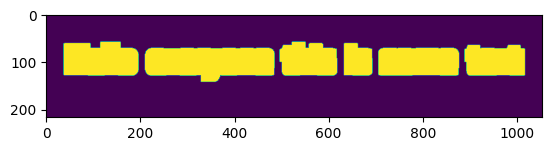

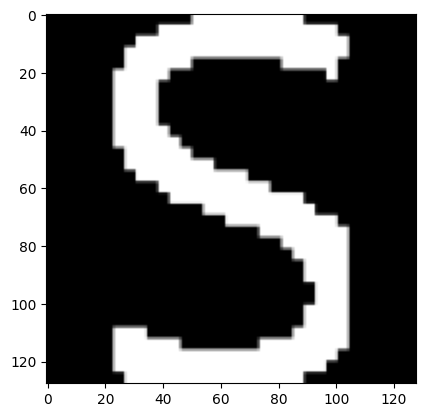

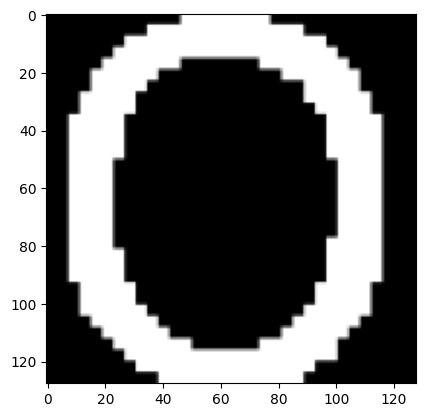

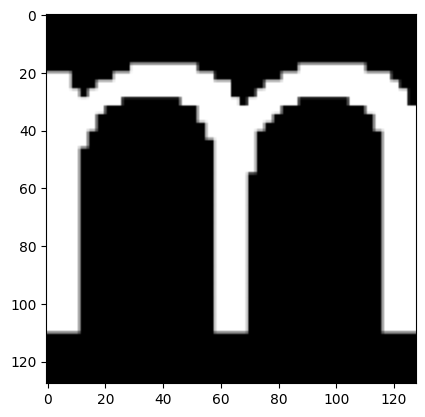

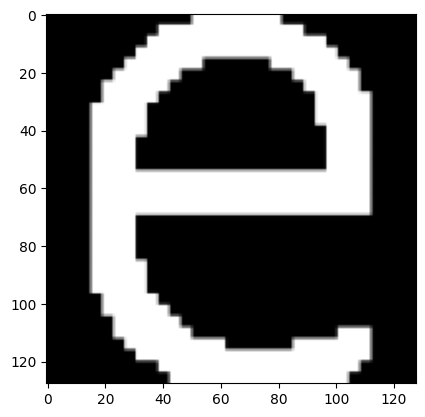

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Lowercase Prediction: s (Confidence: [0.99988794])
Uppercase Prediction: S (Confidence: [0.9598403])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Lowercase Prediction: o (Confidence: [0.9991916])
Uppercase Prediction: O (Confidence: [0.97803736])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Lowercase Prediction: m (Confidence: [0.999997])
Uppercase Prediction: M (Confidence: [0.8181796])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Lowercase Prediction: e (Confidence: [0.99241865])
Uppercase Prediction: E (Confidence: [0.5337217])


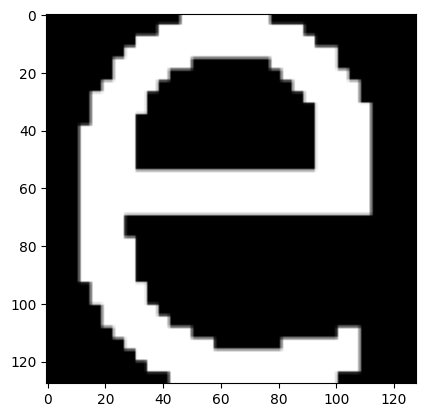

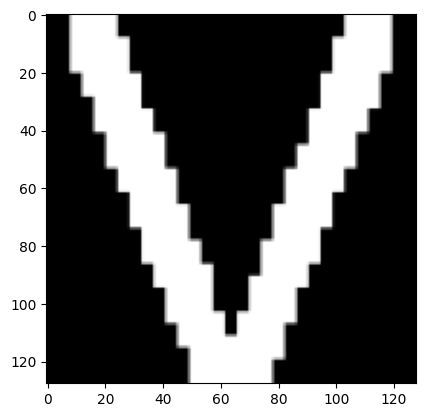

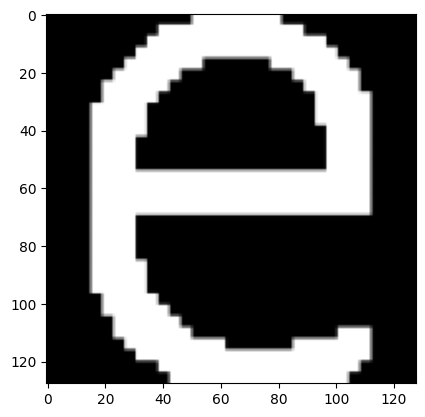

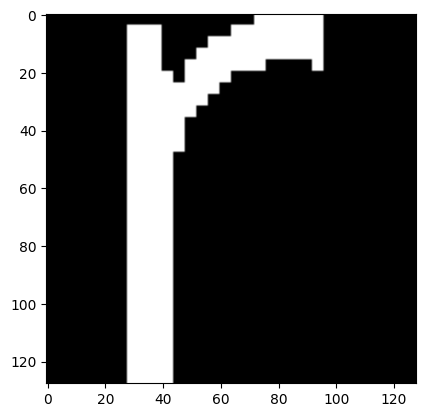

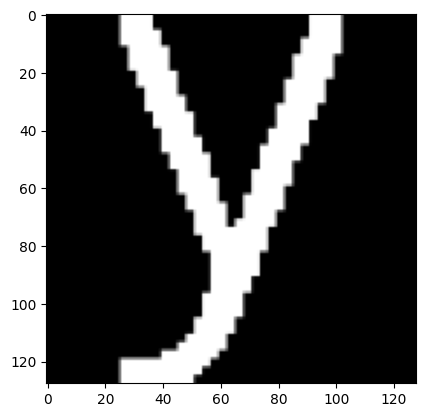

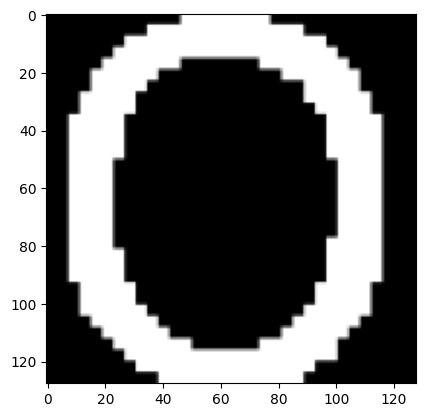

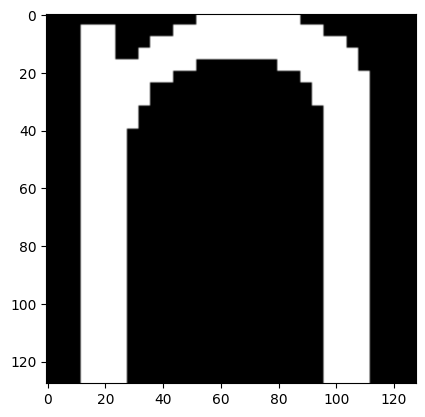

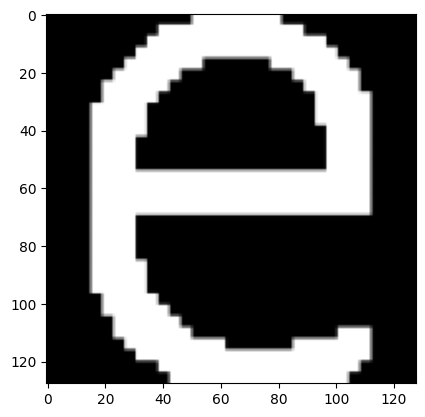

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Lowercase Prediction: e (Confidence: [0.98626804])
Uppercase Prediction: C (Confidence: [0.5869402])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Lowercase Prediction: v (Confidence: [0.9996563])
Uppercase Prediction: V (Confidence: [0.9996911])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Lowercase Prediction: e (Confidence: [0.99241865])
Uppercase Prediction: E (Confidence: [0.5337217])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Lowercase Prediction: r (Confidence: [0.98954844])
Uppercase Prediction: L (Confidence: [0.4025898])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Lowercase Prediction: y (Confidence: [0.998415])
Uppercase Prediction: Y (Confidence: [0.94903654])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Lowercase Prediction: o (Confidence: [0.

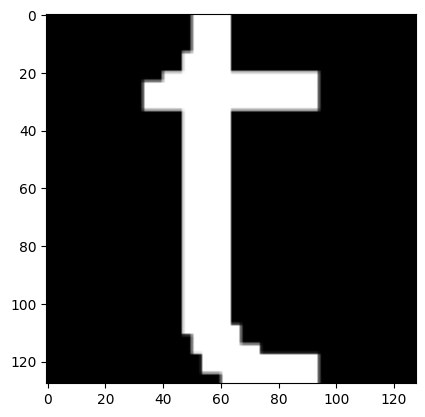

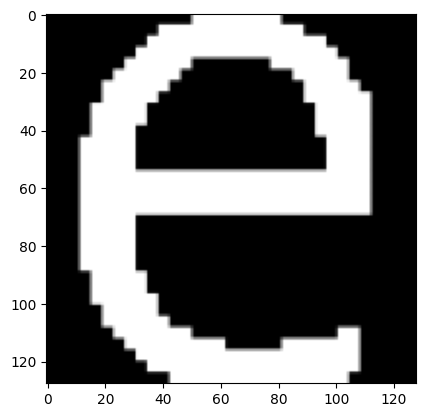

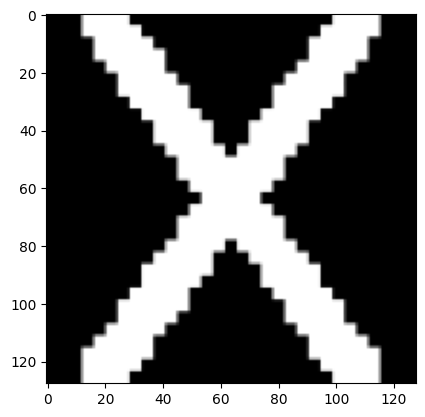

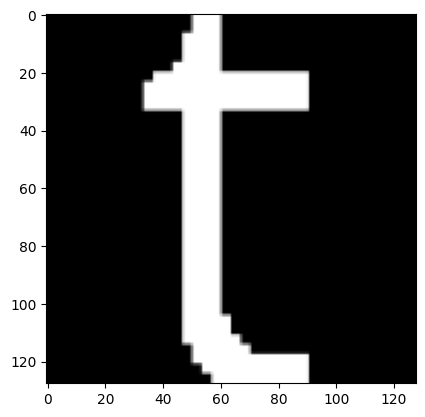

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Lowercase Prediction: t (Confidence: [0.9988985])
Uppercase Prediction: L (Confidence: [0.52127624])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Lowercase Prediction: e (Confidence: [0.98145664])
Uppercase Prediction: C (Confidence: [0.632789])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Lowercase Prediction: x (Confidence: [0.9999833])
Uppercase Prediction: X (Confidence: [0.9999939])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Lowercase Prediction: t (Confidence: [0.99805224])
Uppercase Prediction: L (Confidence: [0.36520144])


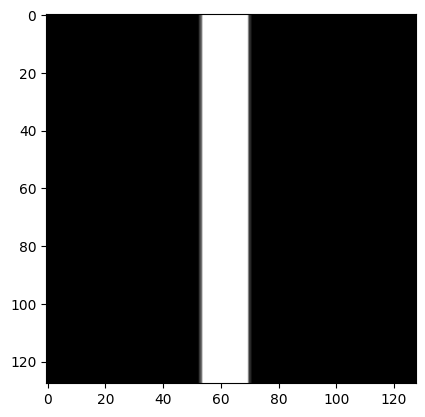

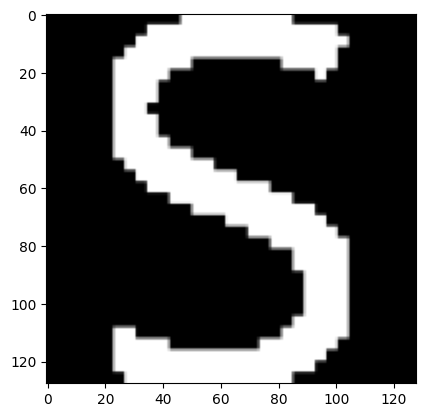

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Lowercase Prediction: l (Confidence: [0.8884798])
Uppercase Prediction: I (Confidence: [0.81447184])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Lowercase Prediction: s (Confidence: [0.99995077])
Uppercase Prediction: S (Confidence: [0.9547907])


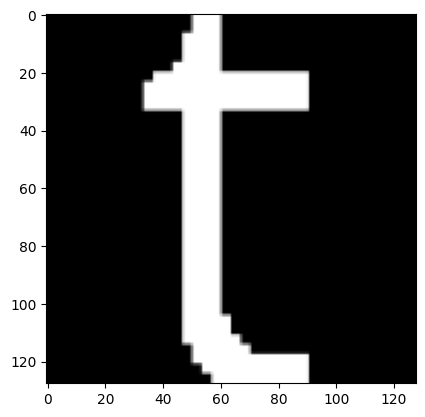

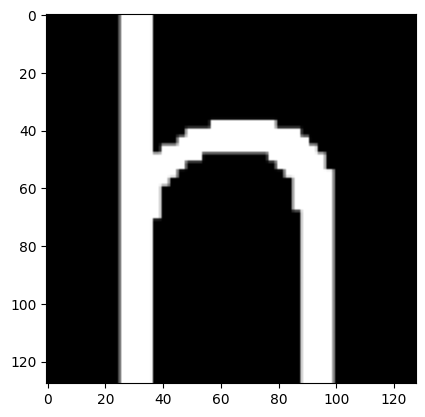

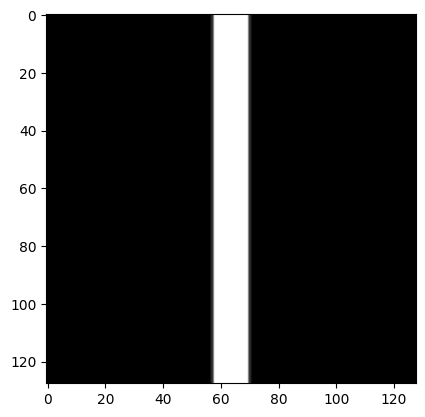

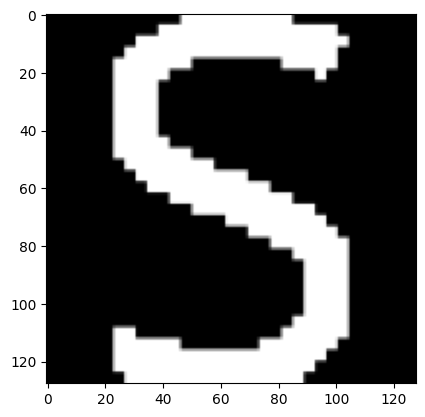

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Lowercase Prediction: t (Confidence: [0.99805224])
Uppercase Prediction: L (Confidence: [0.36520144])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Lowercase Prediction: h (Confidence: [0.96471477])
Uppercase Prediction: L (Confidence: [0.5458638])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Lowercase Prediction: l (Confidence: [0.9267786])
Uppercase Prediction: I (Confidence: [0.75397426])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Lowercase Prediction: s (Confidence: [0.9999336])
Uppercase Prediction: S (Confidence: [0.96101767])


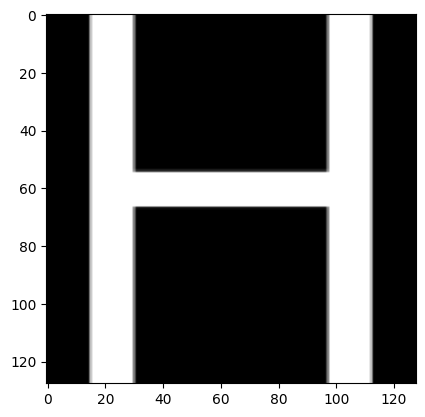

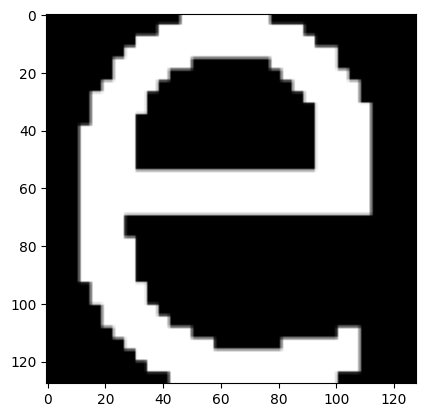

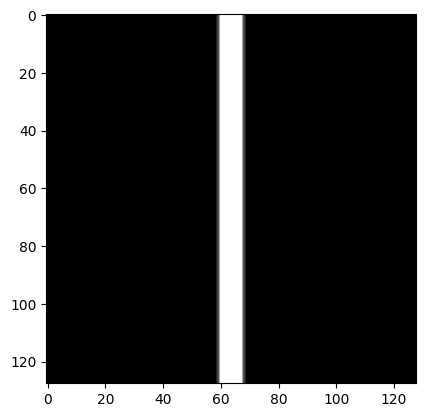

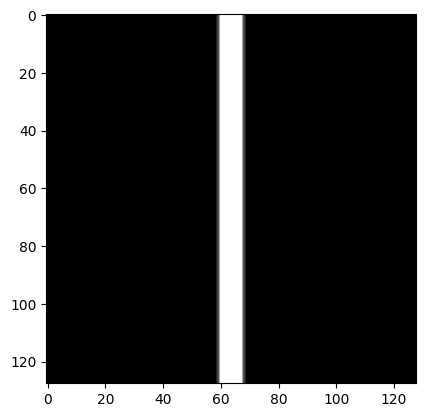

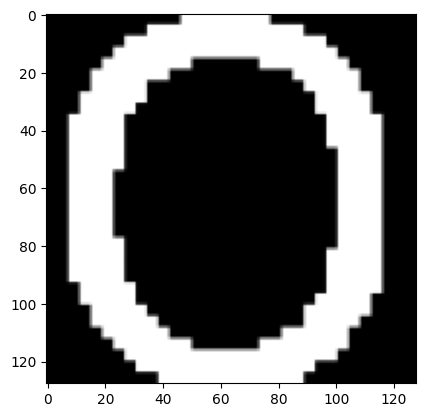

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Lowercase Prediction: u (Confidence: [0.552764])
Uppercase Prediction: H (Confidence: [0.99576133])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Lowercase Prediction: e (Confidence: [0.98626804])
Uppercase Prediction: C (Confidence: [0.5869402])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Lowercase Prediction: l (Confidence: [0.9530669])
Uppercase Prediction: I (Confidence: [0.8442244])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Lowercase Prediction: l (Confidence: [0.9530669])
Uppercase Prediction: I (Confidence: [0.8442244])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Lowercase Prediction: o (Confidence: [0.9978927])
Uppercase Prediction: O (Confidence: [0.97172946])


In [26]:
marked_img = mark_words('./imgs/samp7.png', model)
# cv2.imwrite('marked.png', marked_img)

from PIL import Image

im = Image.fromarray(marked_img)
im.save('marked4.png')